# Test setup

This package requires a lot of annoying dependencies that all need to talk to each
other.

This notebook aims to facilitate with troubleshooting these by testing whether they are accessible.

## `nvidia-smi` / GPU drivers

This tests whether the `nvidia-smi` binary is accessible and returns the correct driver
versions.

This should be available if the NVIDIA GPU driver was intalled with CUDA support.

In [1]:
import subprocess

proc = subprocess.run("nvidia-smi")

if proc.returncode:
    print("Error in running nvidia-smi:", proc.stderr)

Tue Nov 12 01:08:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:17:00.0 Off |                    0 |
|  0%   41C    P0             90W /  300W |       4MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## `jax`

The `jax` and `jaxlib` libraries can be a bit annoying to interface with the GPU. This
checks whether they can correctly get imported and place a tensor on the GPU.

It also tries to set the XLA flags to ensure that it can do GEMM acceleration.

In [2]:
import os

xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += "--xla_gpu_triton_gemm_any=True "
xla_flags += "--xla_gpu_enable_triton_softmax_fusion=true "
os.environ["XLA_FLAGS"] = xla_flags

import jax
import jax.numpy as jnp

print("JAX version:", jax.__version__)

# Print XLA bridge backend info
print("XLA bridge backend:", jax.lib.xla_bridge.get_backend().platform_version)

# Print available devices
print("JAX devices:", jax.devices())

# Test a simple GPU operation
x = jnp.ones((100, 100))
print("Device for allocated tensor:", x.addressable_data(0).device)

JAX version: 0.4.35


/tmp/ipykernel_34586/4154785211.py:14: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print("XLA bridge backend:", jax.lib.xla_bridge.get_backend().platform_version)


XLA bridge backend: PJRT C API
cuda 12030
JAX devices: [CudaDevice(id=0)]
Device for allocated tensor: cuda:0


## EGL renderer

The following checks whether we can import MuJoCo with the EGL backend set.

This requires GPU acceleration and that the NVIDIA EGL drivers are accessible.

On an NVIDIA-based container runtime, this is enabled by setting the
`NVIDIA_DRIVER_CAPABILITIES` environment variable to `all` when running the container.

If this is not possible, the alternative is to use the `osmesa` renderer which runs
(much more slowly) on the CPU.

In [3]:
import os

os.environ["MUJOCO_GL"] = "egl"

try:
    print("Checking that we can import MuJoCo with EGL backend...")
    import mujoco

    mujoco.MjModel.from_xml_string("<mujoco/>")
    print("Success!")
except Exception as e:
    print("Error in importing mujoco:", e)

Checking that we can import MuJoCo with EGL backend...
Success!


""

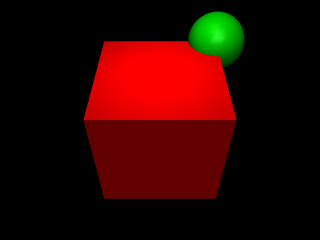

In [4]:
import mediapy

xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)

    mediapy.show_image(renderer.render())